Cases we could explore :
1. Univariate gaussians with the same variance (most simple case) : the OT map is just an affine function, so $W_1$ is the distance between the means ;
2. Univariate distributions : the formula $ W_1(\mu, \nu) = \int_\mathbb{R} |F_\mu(t) - F_\nu(t)| dt $ can give us an explicit value for $W_1$ in some cases (e.g. exponential);
3. Gaussian distributions : we know the ground truth optimal map associated to $W_2$, but the WGAN approach only approximates $W_1$ as is ;
4. Discrete probability measures: the exact optimal map can be computed (although it can take long with lots of samples) ;
5. Possibly any other case where we can obtain a good approximation of $W_1$ with the Sinkhorn algorithm.

In [30]:
# Mathematical operations and statistical tools
import numpy as np
from scipy import stats, spatial

# Optimal transport
try:
    import ot
except ModuleNotFoundError:
    !pip install POT
    import ot

# Deep learning library
import torch

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Typing
from typing import Union, Callable, List, Optional

import warnings
warnings.filterwarnings('ignore')

We fix the numpy random seed and the device (the code can be run on CPU in a reasonable amount of time).

In [31]:
np.random.seed(44)
torch.manual_seed(44)
#if torch.cuda.is_available():
 #   torch.set_default_tensor_type('torch.cuda.FloatTensor')
 #   device = torch.device('cuda')
#else:
#    torch.set_default_tensor_type('torch.FloatTensor')
#    device = torch.device('cpu')
#print(device)

The following class allows to build a dataset from two distributions. This will be used to train out models.

In [32]:
class RandomDataset(torch.utils.data.Dataset):
    """Creates a dataset of `size` samples from two distributions."""
    def __init__(
        self,
        mu: Union[stats.rv_continuous, stats.rv_discrete],
        nu: Union[stats.rv_continuous, stats.rv_discrete],
        size: int = 2_000
    ):
        xs = mu.rvs(size=size)
        ys = nu.rvs(size=size)
        self.xs = torch.from_numpy(xs).reshape((size, -1))
        self.ys = torch.from_numpy(ys).reshape((size, -1))

    def __len__(self):
        return self.xs.shape[0]
      
    def __getitem__(self, idx: int):
        return dict(
            origin = self.xs[idx,...],
            target = self.ys[idx,...]
        )

# 1. Univariate gaussians with the same variance
$$
    \mu = \mathcal{N}_1(-2, 1) \quad \nu = \mathcal{N}_1(2, 1)
$$

The optimal map is 
$$
    T \colon x \to x+4
$$

And hence the cost of this map is
$$
    W_1(\mu, \nu) = \int_\mathbb{R} |x-T(x)|d\mu(x) = \int_\mathbb{R} 4d\mu(x) = 4
$$

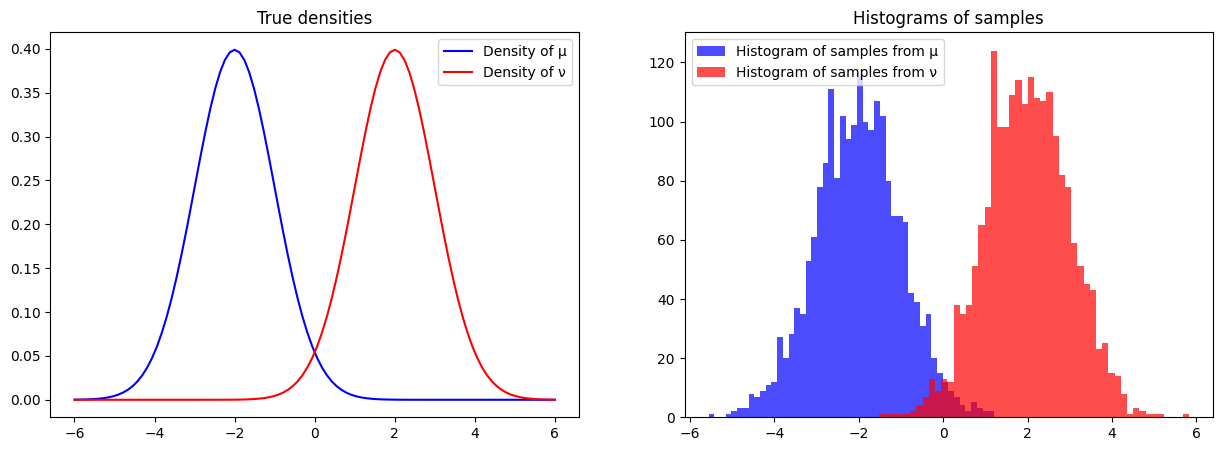

In [33]:
mu = stats.norm(-2, 1)
nu = stats.norm(2, 1)
    
dataset = RandomDataset(mu, nu)

fig, (left, right) = plt.subplots(1, 2, figsize=(15,5))
ticks = np.linspace(-6, 6, 100)
densite_mu = np.vectorize(mu.pdf)(ticks)
densite_nu = np.vectorize(nu.pdf)(ticks)
left.plot(ticks, densite_mu, color='blue', label='Density of μ')
left.plot(ticks, densite_nu, color='red', label='Density of ν')
right.hist(dataset.xs.detach().numpy(), bins=50, color='blue', alpha=.7, label='Histogram of samples from μ')
right.hist(dataset.ys.detach().numpy(), bins=50, color='red', alpha=.7, label='Histogram of samples from ν')
left.legend()
right.legend()
left.set_title("True densities")
right.set_title("Histograms of samples");

## 1.1. Approximation with a neural network

To approximate $W_1$ with a neural network, we use its dual representation 

\begin{align*}
    W_1(\mu,\nu) & = \sup_{f \in \text{Lip}_1(\mathbb{R},\mathbb{R})}  \int_\mathbb{R} f d(\mu-\nu) \\
    & = \sup_{f \in \text{Lip}_1(\mathbb{R},\mathbb{R})} \mathbb{E}_{(x,y)\sim\mu\otimes\nu}[f(x)-f(y)]
\end{align*}

To this end, we approximate :
- the expectation with the empirical mean from a sample from the distribution $\mu\otimes\nu$ ;
- and the function $f$ by a feed-forward neural network (to enforce the Lipschitz constraint, we apply spectral normalization on the linear layers).

In [34]:
from torch.nn.utils.parametrizations import spectral_norm # To enforce the 1-Lipschitz constraint

model = torch.nn.Sequential(
    spectral_norm(torch.nn.Linear(1, 8)),
    torch.nn.ReLU(),
    spectral_norm(torch.nn.Linear(8, 8)),
    torch.nn.ReLU(),
    spectral_norm(torch.nn.Linear(8, 1)),
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, drop_last=True, shuffle=True)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, maximize=True)

In [35]:
def train(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    nb_epochs: int = 100,
):
    losses = []

    for epoch in range(nb_epochs):
        model.train()
        train_loss = 0.0

        for batch in dataloader:
            optimizer.zero_grad()

            x = batch['origin'].float()
            y = batch['target'].float()
            fx = model(x)
            fy = model(y)

            loss = torch.sum(fx - fy)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

        # Print loss ~10 times
        if (epoch+1)%(nb_epochs//10) == 0: print(f'Epoch {epoch+1}/{nb_epochs}, training loss: {train_loss/len(dataloader)/100:.4g}')
        losses.append(train_loss/len(dataloader)/100)
    
    return losses

In [36]:
losses = train(
    model = model,
    dataloader = dataloader,
    optimizer = optimizer,
    nb_epochs = 100
)

Epoch 10/100, training loss: 3.713
Epoch 20/100, training loss: 3.888
Epoch 30/100, training loss: 3.947
Epoch 40/100, training loss: 3.977
Epoch 50/100, training loss: 3.992
Epoch 60/100, training loss: 4
Epoch 70/100, training loss: 4.004
Epoch 80/100, training loss: 4.005
Epoch 90/100, training loss: 4.006
Epoch 100/100, training loss: 4.006


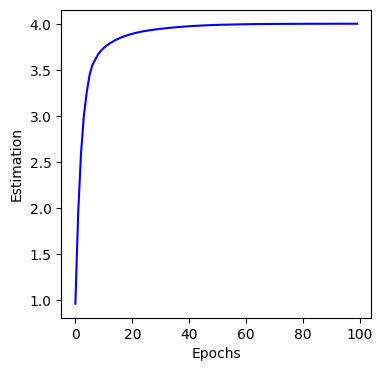

In [37]:
def plot_progress(losses: List[float], title:Optional[str]=None):
    fig, ax = plt.subplots(figsize=(4,4))
    ax.plot(losses, color='blue')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Estimation')
    if title is not None:
        ax.set_title(title)

plot_progress(losses)

The estimated Wasserstein distance is the opposite of the loss of the trained model, i.e. 
$$
    \hat W_1^N(\hat\mu_n, \hat\nu_n) \approx 4.006
$$

In this case the relative error is 0.15\%. Let us now compare it to a standard OT algorithm: the Sinkhorn algorithm.

# 1.2. Approximation with the Sinkhorn algorithm 

The Sinkhorn algorithm solves the following problem

$$
    P^*(\gamma) = \arg\min_P \langle P, C \rangle + \gamma E(P)
$$

where $C$ is the cost matrix between the samples defined by 

$$
    C_{i,j} = |x_i - y_j |
$$

$\gamma$ is a regularization hyperparameter and $E(P)$ is the entropy of $P$ :       

$$
    E(P) = \sum_{i,j} P_{i,j}\log(P_{i,j})
$$

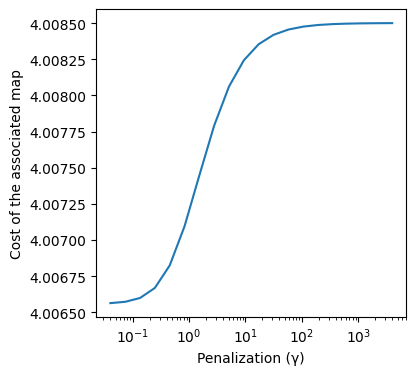

In [38]:
def solve_sinkhorn(xs, ys, log_gamma_min=-2, log_gamma_max=3):
    C = spatial.distance.cdist(
        xs, ys,
        metric = 'cityblock'
    )

    results = []
    gammas = np.logspace(log_gamma_min, log_gamma_max, 20)
    c_mean = np.mean(C)
    for gamma in gammas:
        P = ot.bregman.sinkhorn([], [], C, reg=gamma*c_mean)
        results.append(np.sum(C*P))

    fig, ax = plt.subplots(figsize=(4,4))
    ax.plot(gammas*c_mean, results)
    ax.set_xscale('log')
    ax.set_xlabel('Penalization (γ)')
    ax.set_ylabel('Cost of the associated map')

    return results

results = solve_sinkhorn(dataset.xs, dataset.ys)

With an appropriate choice of $\gamma = 10^{-2}$, we obtain 

$$
    \hat W_1^S(\hat\mu_n, \hat\nu_n) \approx 4.007
$$

In this particular case, both methods approximate very well the true 1-Wasserstein distance.

# 2. Exponential distributions

$$
    \mu = \mathcal{E}(\kappa) \quad \nu = \mathcal{E}(\lambda)
$$

where $ \kappa \geq \lambda$ are *scale* parameters. To compute the Wassertstein distance, we use the following representation :

\begin{align*}
    W_1(\mu, \nu) & = \int_\mathbb{R} |F_\mu(t) - F_\nu(t)| dt \\ 
    & = \int_\mathbb{R_+} | 1 - e^{-t/\kappa} - (1 - e^{-t/\lambda}) | dt \\
    & = \int_\mathbb{R_+} (e^{-t/\kappa} - e^{-t/\lambda}) dt \\
    & = \left[ \lambda e^{-t/\lambda} - \kappa e^{-t/\kappa}\right]_{t=0}^\infty \\
    & = \kappa - \lambda
\end{align*}

In the following experiment, we consider $\kappa = 3$ and $\lambda = 1$, so

$$
    W_1(\mu,\nu) = 2
$$

Epoch 10/100, training loss: 1.864
Epoch 20/100, training loss: 1.968
Epoch 30/100, training loss: 1.971
Epoch 40/100, training loss: 1.972
Epoch 50/100, training loss: 1.971
Epoch 60/100, training loss: 1.971
Epoch 70/100, training loss: 1.971
Epoch 80/100, training loss: 1.971
Epoch 90/100, training loss: 1.971
Epoch 100/100, training loss: 1.971


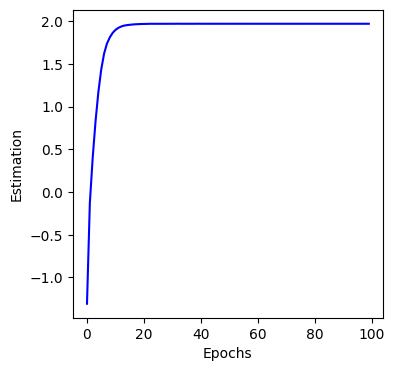

In [39]:
def wgam_expo(mu,nu):
    
    mu = stats.expon(mu)
    nu = stats.expon(nu)
    
    
    dataset = RandomDataset(mu, nu)
    
    model = torch.nn.Sequential(
    spectral_norm(torch.nn.Linear(1, 8)),
    torch.nn.ReLU(),
    spectral_norm(torch.nn.Linear(8, 8)),
    torch.nn.ReLU(),
    spectral_norm(torch.nn.Linear(8, 1)),
    )
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, drop_last=True, shuffle=True)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, maximize=True)
    return dataset, dataloader

dataset=wgam_expo(3, 1)[0]
dataloader=wgam_expo(3, 1)[1]
    

losses = train(model, dataloader, optimizer, nb_epochs=100)
plot_progress(losses)

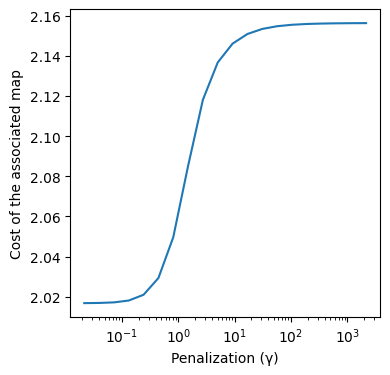

In [40]:
results = solve_sinkhorn(dataset.xs, dataset.ys)

We obtain
$$
    \hat W_1^N(\hat\mu_n, \hat\nu_n) \approx 2.07
$$

and 

$$
    \hat W_1^S(\hat\mu_n, \hat\nu_n) \approx 2.07
$$

Again, both methods provide a similar approximation.

### Check for other values of the mean

Epoch 10/100, training loss: 0.4993
Epoch 20/100, training loss: 0.5305
Epoch 30/100, training loss: 0.5312
Epoch 40/100, training loss: 0.5314
Epoch 50/100, training loss: 0.5315
Epoch 60/100, training loss: 0.5316
Epoch 70/100, training loss: 0.5316
Epoch 80/100, training loss: 0.5316
Epoch 90/100, training loss: 0.5316
Epoch 100/100, training loss: 0.5316


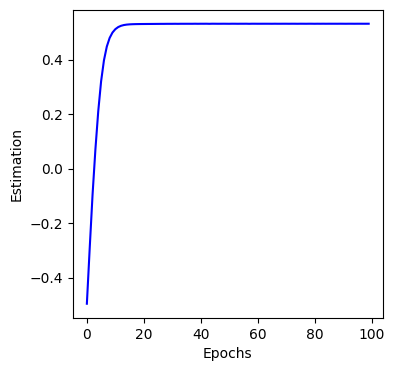

In [41]:
dataset=wgam_expo(1/2, 1)[0]
dataloader=wgam_expo(1/2, 1)[1]
    

losses = train(model, dataloader, optimizer, nb_epochs=100)
plot_progress(losses)

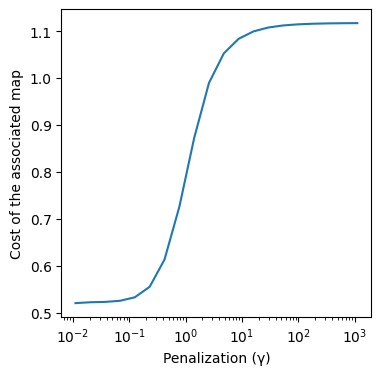

In [42]:
results = solve_sinkhorn(dataset.xs, dataset.ys)

Epoch 10/100, training loss: 3.883
Epoch 20/100, training loss: 3.948
Epoch 30/100, training loss: 3.952
Epoch 40/100, training loss: 3.953
Epoch 50/100, training loss: 3.953
Epoch 60/100, training loss: 3.953
Epoch 70/100, training loss: 3.953
Epoch 80/100, training loss: 3.953
Epoch 90/100, training loss: 3.953
Epoch 100/100, training loss: 3.953


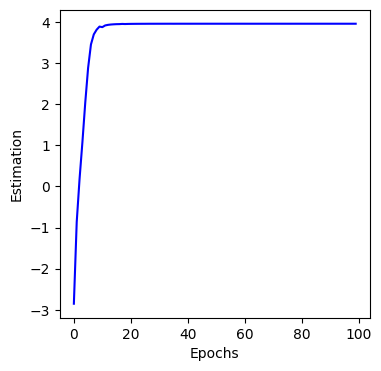

In [43]:
dataset=wgam_expo(5, 1)[0]
dataloader=wgam_expo(5, 1)[1]
    

losses = train(model, dataloader, optimizer, nb_epochs=100)
plot_progress(losses)

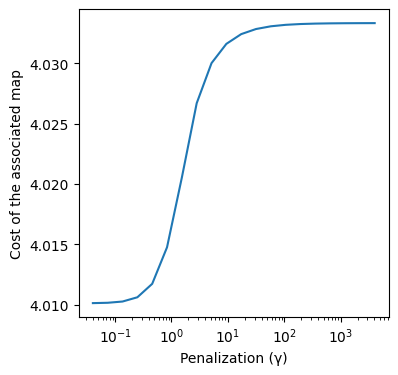

In [44]:
results = solve_sinkhorn(dataset.xs, dataset.ys)

Epoch 10/100, training loss: 3.03
Epoch 20/100, training loss: 3.03
Epoch 30/100, training loss: 3.03
Epoch 40/100, training loss: 3.03
Epoch 50/100, training loss: 3.03
Epoch 60/100, training loss: 3.03
Epoch 70/100, training loss: 3.03
Epoch 80/100, training loss: 3.03
Epoch 90/100, training loss: 3.03
Epoch 100/100, training loss: 3.03


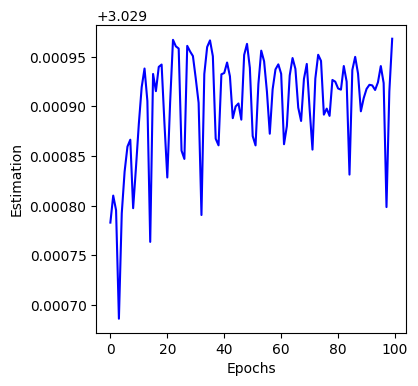

In [45]:
dataset=wgam_expo(5, 2)[0]
dataloader=wgam_expo(5, 2)[1]
    

losses = train(model, dataloader, optimizer, nb_epochs=100)
plot_progress(losses)

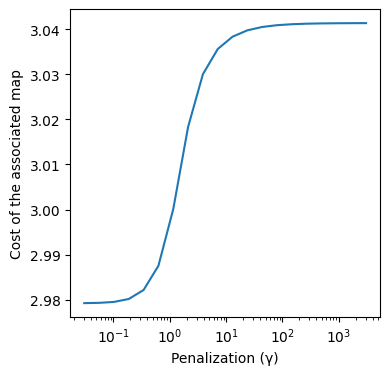

In [46]:
results = solve_sinkhorn(dataset.xs, dataset.ys)

# 3. Geometric distributions

With $\mu \sim \mathcal G\left(\frac12\right)$ and $\nu \sim \mathcal G\left(\frac14\right)$, we have

$$ W_1(\mu,\nu) = \frac1q - \frac1p = 4 - 2 = 2 $$

Epoch 10/100, training loss: 1.217
Epoch 20/100, training loss: 1.957
Epoch 30/100, training loss: 2.006
Epoch 40/100, training loss: 2.012
Epoch 50/100, training loss: 2.013
Epoch 60/100, training loss: 2.013
Epoch 70/100, training loss: 2.013
Epoch 80/100, training loss: 2.013
Epoch 90/100, training loss: 2.013
Epoch 100/100, training loss: 2.013


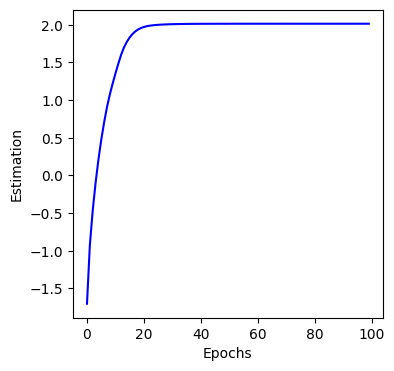

In [47]:
def wgam_geo(mu,nu):
    
    mu = stats.geom(mu)
    nu = stats.geom(nu)
    
    
    dataset = RandomDataset(mu, nu)
    
    model = torch.nn.Sequential(
    spectral_norm(torch.nn.Linear(1, 8)),
    torch.nn.ReLU(),
    spectral_norm(torch.nn.Linear(8, 8)),
    torch.nn.ReLU(),
    spectral_norm(torch.nn.Linear(8, 1)),
    )
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, drop_last=True, shuffle=True)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, maximize=True)
    return dataset, dataloader

dataset=wgam_geo(1/2, 1/4)[0]
dataloader=wgam_geo(1/2, 1/4)[1]
    

losses = train(model, dataloader, optimizer, nb_epochs=100)
plot_progress(losses)


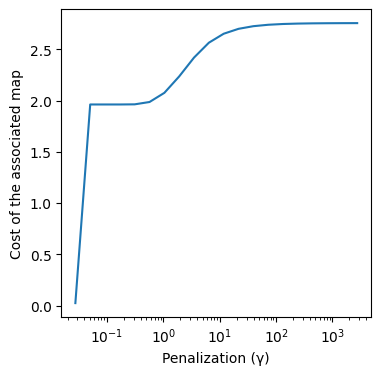

In [48]:
results = solve_sinkhorn(dataset.xs, dataset.ys)

### check for others mean

Epoch 10/100, training loss: 1.166
Epoch 20/100, training loss: 1.67
Epoch 30/100, training loss: 1.899
Epoch 40/100, training loss: 2.079
Epoch 50/100, training loss: 2.255
Epoch 60/100, training loss: 2.424
Epoch 70/100, training loss: 2.578
Epoch 80/100, training loss: 2.697
Epoch 90/100, training loss: 2.807
Epoch 100/100, training loss: 2.901


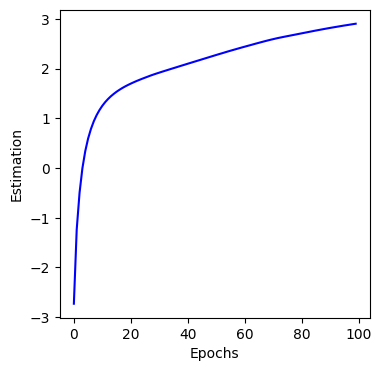

In [49]:
dataset=wgam_geo(1/8, 1/4)[0]
dataloader=wgam_geo(1/8, 1/4)[1]
    

losses = train(model, dataloader, optimizer, nb_epochs=100)
plot_progress(losses)

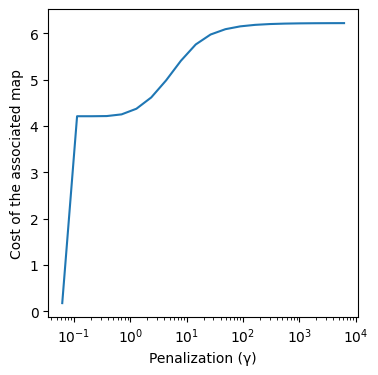

In [50]:
results = solve_sinkhorn(dataset.xs, dataset.ys)

Epoch 10/100, training loss: 0.8868
Epoch 20/100, training loss: 1.907
Epoch 30/100, training loss: 1.968
Epoch 40/100, training loss: 2.001
Epoch 50/100, training loss: 2.031
Epoch 60/100, training loss: 2.072
Epoch 70/100, training loss: 2.112
Epoch 80/100, training loss: 2.13
Epoch 90/100, training loss: 2.133
Epoch 100/100, training loss: 2.135


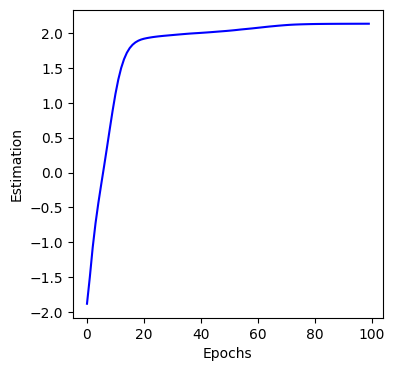

In [51]:
dataset=wgam_geo(1/3, 1/5)[0]
dataloader=wgam_geo(1/3, 1/5)[1]
    

losses = train(model, dataloader, optimizer, nb_epochs=100)
plot_progress(losses)

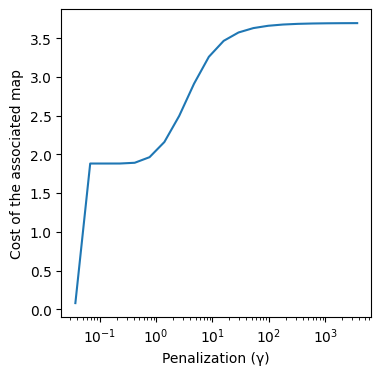

In [52]:
results = solve_sinkhorn(dataset.xs, dataset.ys)